# Acadamic Success Multi class pridiction (Catboost,light gbm,xgb,Random Jungle)
### by Ayush kumar
### Data scientist


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Loading and Merging the Data set

In [2]:
train_data=pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv',index_col=[0])
test_data=pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv',index_col=[0])

orignal_data=pd.read_csv('/kaggle/input/acadmic-compitition-swag/data.csv',sep=';')
print(train_data.shape)
print(orignal_data.shape)

(76518, 37)
(4424, 37)


In [3]:
train_data.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

In [4]:
orignal_data.rename(columns={'Daytime/evening attendance\t':'Daytime/evening attendance'},inplace=True)

In [5]:
df=pd.concat([train_data,orignal_data],axis=0)

In [6]:
df.reset_index(drop=True,inplace=True)

In [7]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [8]:
train_data=df.copy()

### Importing Required Libraries

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import classification_report,accuracy_score
import warnings
warnings.filterwarnings('ignore')

### Basic preprocessing and EDA

In [10]:
num_cols=train_data.select_dtypes(exclude='object').columns.to_list()
num_cols

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance',
 'Previous qualification',
 'Previous qualification (grade)',
 'Nacionality',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 "Father's occupation",
 'Admission grade',
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'International',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rat

<Axes: xlabel='Marital status', ylabel='count'>

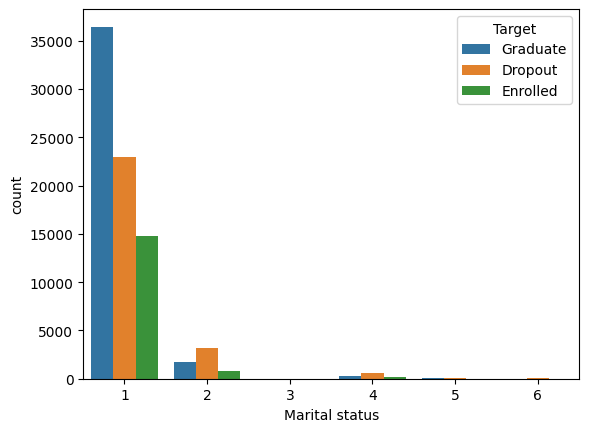

In [11]:
sns.countplot(data=df,x=df['Marital status'],hue=df['Target'])

<Axes: xlabel='Gender', ylabel='count'>

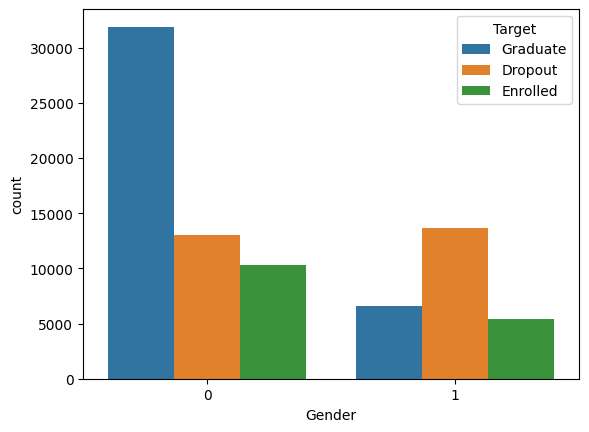

In [26]:
sns.countplot(data=df,x=df['Gender'],hue=df['Target'])

<Axes: ylabel='Density'>

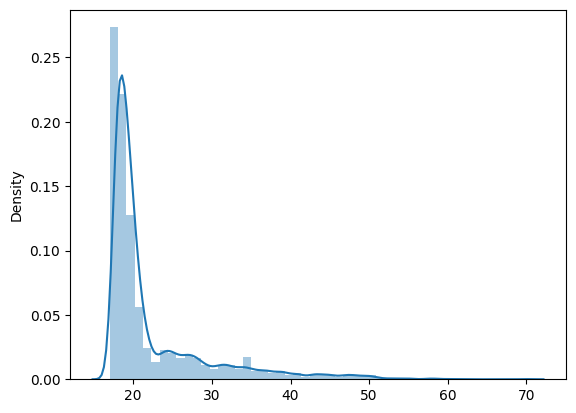

In [25]:
sns.distplot(df,x=df['Age at enrollment'])


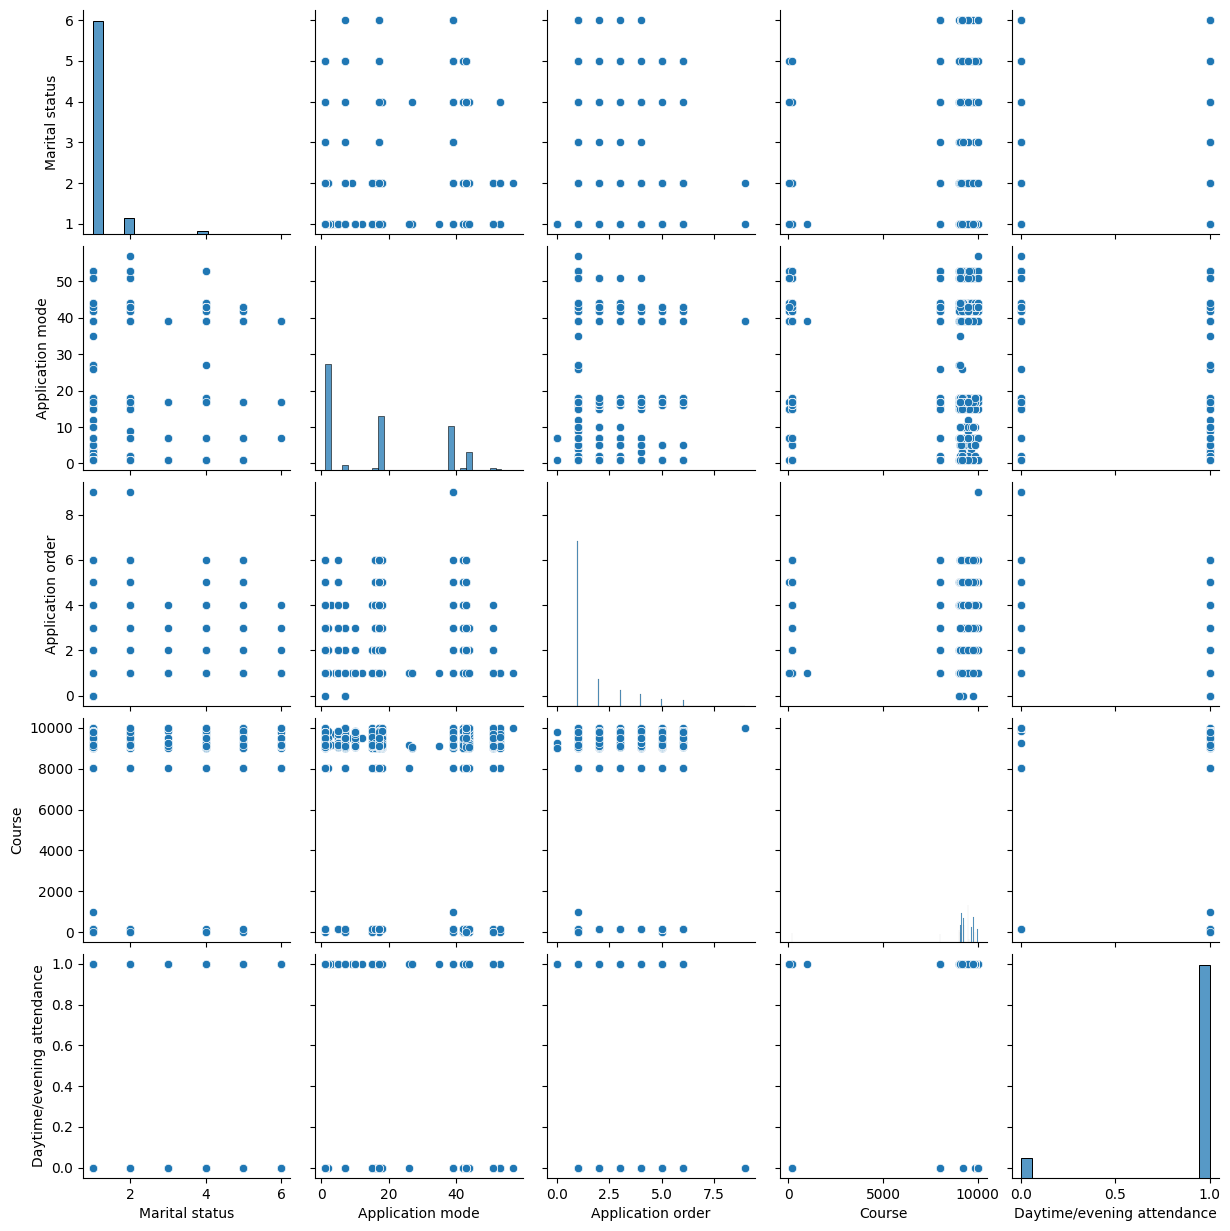

In [17]:
sns.pairplot(df[num_cols[:5]])

#### Preprocessing pipeline

In [27]:

X=train_data.drop(columns=['Target'],axis=1)
y=train_data['Target']

In [28]:
line=Pipeline(steps=[("IMPUTE",SimpleImputer(strategy='median')),("SCALING",StandardScaler())])
line

Pipeline(steps=[('IMPUTE', SimpleImputer(strategy='median')),
                ('SCALING', StandardScaler())])

In [29]:
train_data=line.fit_transform(X)
test_data=line.transform(test_data)

In [30]:
lr=LabelEncoder()
y=lr.fit_transform(y)

In [31]:
y

array([2, 0, 0, ..., 0, 2, 2])

## Model Spliting

In [32]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(64753, 36)
(16189, 36)
(64753,)
(16189,)


## CAT BOOSTER CLASSIFIER

In [34]:
cat_boost=CatBoostClassifier(verbose=False)
cat_boost.fit(X_train,y_train)
y_pred=cat_boost.predict(X_test)
report=classification_report(y_pred,y_test)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4988
           1       0.60      0.67      0.63      2851
           2       0.93      0.86      0.89      8350

    accuracy                           0.84     16189
   macro avg       0.79      0.81      0.80     16189
weighted avg       0.84      0.84      0.84     16189



In [ ]:
# Run only when working with Catboost
# # Hyperparameter tuning
# import warnings
# warnings.filterwarnings('ignore')
# import optuna
# # from optuna.integration import OptunaSearch
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 100),
#         'random_strength': trial.suggest_loguniform('random_strength', 1e-5, 100),
#         'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-6, 1.0),
# #         'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.0, 1.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'verbose': 0
#     }

#     model = CatBoostClassifier(**params,task_type='GPU')
#     model.fit(X_train, y_train,eval_set=(X_test,y_test),verbose=False,early_stopping_rounds=20)
#     accuracy=model.score(X_test,y_test)
    
#     return accuracy

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [ ]:
# params=study.best_params

In [ ]:
# cat_boost=CatBoostClassifier(verbose=False,**params)
# cat_boost.fit(X_train,y_train)
# y_pred=cat_boost.predict(X_test)
# report=classification_report(y_pred,y_test)
# print(report)

## Final Model

In [35]:
clf1=CatBoostClassifier()
clf2 = XGBClassifier(
    n_estimators=853,
    max_depth=5,
    learning_rate=0.041458853292752534,
    gamma=0.3555203770418791,
    subsample=0.7899148138439865,
    colsample_bytree=0.5265172370215713,
    reg_lambda=0.09448624708202247,
    reg_alpha=0.03959470816275879,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
clf3 = LGBMClassifier(
    num_leaves=28,
    max_depth=11,
    learning_rate=0.06228445168155766,
    n_estimators=329,
    min_child_samples=14,
    subsample=0.6298418946251059,
    colsample_bytree=0.515337546519447,
    reg_alpha=3.9855294313236715e-06,
    reg_lambda=0.046168765973349575
)

clf4=RandomForestClassifier()


In [36]:
final_model=VotingClassifier(estimators=[('CAT',clf1),('XGB',clf2),('LGBM',clf3),('RAND',clf4)],voting='soft',verbose=False)

In [37]:
final_model

VotingClassifier(estimators=[('CAT',
                              <catboost.core.CatBoostClassifier object at 0x79bd32d77130>),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5265172370215713,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None,
                                            gamm...
                                            n_estimators=853, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('LGBM',
                              LGBMClassifier(colsample_bytree=0.515337546519447,
                                             learning_rate=0.06228445168155766,
                                             max_depth=11, min_child_samples=14,
                                             n_estimators=329, num_leaves=28,
                                             reg_alpha=3.9855294313236715e-06,
                                             reg_lambda=0.046168765973349575,
                                             subsample=0.6298418946251059)),
                             ('RAND', RandomForestClassifier())],
                 voting='soft')

In [ ]:
final_model.fit(X_train,y_train)

In [ ]:
yhat=final_model.predict(X_test)
print(classification_report(y_test,yhat))

In [ ]:
train_data.shape
test_data.shape

In [ ]:
final_model.fit(train_data,y)

In [ ]:
yhat=final_model.predict(test_data)

In [ ]:
yhat

In [ ]:
yhat=lr.inverse_transform(yhat)

In [ ]:
test=pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv',index_col=[0])

In [ ]:
pd.DataFrame({'id':test.index,
             'Target':yhat}).to_csv("OG.csv",index=False)